# Preprocess Data for the Masking Layer Keras

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep

import os
import warnings

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, callbacks, regularizers

In [22]:
hep.style.use("CMS")

warnings.filterwarnings("ignore")

mpl.rcParams["figure.dpi"] = 80
FIGSIZE = (7,5)


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', None)

In [23]:
print(f"Training device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

Training device: GPU


In [24]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [25]:
USER = os.getenv("USER")

# FILE_PATH = "/eos/cms/store/cmst3/group/daql1scout/ml_data/run3/bmtf_stubs_refit/"
FILE_PATH = "/mnt/ml_data/run3/bmtf_stubs_refit_dummy/"

FILE_NAME = "rereco"

OUT_PATH = "Plots/"
LOSS_FNAME = "losses.csv"

FIGSIZE = (10, 7)

petroff_10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', petroff_10)

In [26]:
stub_features = [
    'n_stubs', 
    's1_stNum', 's1_scNum', 's1_whNum', 's1_eta_1', 's1_qeta_1', 's1_eta_2', 's1_qeta_2', 's1_tag', 's1_phi', 's1_phiB', 's1_quality', 
    's2_stNum', 's2_scNum', 's2_whNum', 's2_eta_1', 's2_qeta_1', 's2_eta_2', 's2_qeta_2', 's2_tag', 's2_phi', 's2_phiB', 's2_quality', 
    's3_stNum', 's3_scNum', 's3_whNum', 's3_eta_1', 's3_qeta_1', 's3_eta_2', 's3_qeta_2', 's3_tag', 's3_phi', 's3_phiB', 's3_quality', 
    's4_stNum', 's4_scNum', 's4_whNum', 's4_eta_1', 's4_qeta_1', 's4_eta_2', 's4_qeta_2', 's4_tag', 's4_phi', 's4_phiB', 's4_quality'
]

target_features = [
    'ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2', 'chargeReco',
]

l1_features = [
    'ptL1', 'etaL1', 'phiL1', 'hwSignL1',
]

In [38]:
full_data_ = pd.DataFrame()

for file in os.listdir(FILE_PATH):
    if file.endswith(".csv"):
        full_data_ = pd.concat([full_data_, pd.read_csv(FILE_PATH + file)], ignore_index=True)
        print(f"Loaded {file}")
        
full_data_ = full_data_.iloc[:, :-1]

# drop rows with ptL1 == 4.5
full_data_ = full_data_[full_data_["ptL1"] != 4.5]

# drop rows with reco eta > 1 and < -1
full_data_ = full_data_[full_data_["etaExtRecoSt2"] < 1]
full_data_ = full_data_[full_data_["etaExtRecoSt2"] > -1]

# drop rows with ptL1 > 50
full_data_ = full_data_[full_data_["ptL1"] < 256]

# drop rows with ptReco > 50
full_data_ = full_data_[full_data_["ptReco"] < 256]


# mask_1 = (full_data_.etaL1 == 0) & (np.abs(full_data_.etaExtRecoSt2) == 0)
# mask_2 = (full_data_.etaL1 != 0)

# mask = mask_1 | mask_2

# full_data_ = full_data_[mask]

full_data_["ptRecoInverse"] = 1 / full_data_["ptReco"]

full_data = full_data_[stub_features + target_features + l1_features]

full_data["chargeReco"] = full_data["chargeReco"].apply(lambda x: 0 if x == -1 else 1)

Loaded MuonEG-Run2023C-ReReco_100.csv


In [28]:
full_data.head()

,n_stubs,s1_stNum,s1_scNum,s1_whNum,s1_eta_1,s1_qeta_1,s1_eta_2,s1_qeta_2,s1_tag,s1_phi,s1_phiB,s1_quality,s2_stNum,s2_scNum,s2_whNum,s2_eta_1,s2_qeta_1,s2_eta_2,s2_qeta_2,s2_tag,s2_phi,s2_phiB,s2_quality,s3_stNum,s3_scNum,s3_whNum,s3_eta_1,s3_qeta_1,s3_eta_2,s3_qeta_2,s3_tag,s3_phi,s3_phiB,s3_quality,s4_stNum,s4_scNum,s4_whNum,s4_eta_1,s4_qeta_1,s4_eta_2,s4_qeta_2,s4_tag,s4_phi,s4_phiB,s4_quality,ptRecoInverse,etaExtRecoSt2,phiExtRecoSt2,chargeReco,ptL1,etaL1,phiL1,hwSignL1
0,3,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,2,7,-1,-40,2,255,0,1,749,-67,3,3,7,-1,-42,2,255,0,1,687,-15,5,4,7,-1,7,0,7,0,1,696,51,5,0.144291,-0.392203,-2.41475,1,7.0,-0.445875,-2.44346,0
1,4,1,3,1,7,0,7,0,1,935,-133,6,2,3,1,7,0,7,0,1,805,-100,2,3,3,2,62,1,255,0,1,685,-47,5,4,3,2,7,0,7,0,1,667,21,6,0.175805,0.711453,1.74785,1,7.5,0.674250,1.75624,0
2,4,1,10,1,52,1,255,0,1,136,-69,6,2,10,1,55,2,255,0,1,54,-53,6,3,10,1,51,2,255,0,1,-6,-25,2,4,10,2,7,0,7,0,1,-35,-12,6,0.096981,0.584075,-1.04620,1,14.5,0.565500,-1.03629,0
3,4,1,10,1,52,1,255,0,1,136,-69,6,2,10,1,55,2,255,0,1,54,-53,6,3,10,1,51,2,255,0,1,-6,-25,2,4,10,2,7,0,7,0,1,-35,-12,6,0.100442,0.521335,-1.08019,1,14.5,0.565500,-1.03629,0
4,3,1,7,0,7,1,255,0,1,-151,19,6,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,3,7,0,5,2,255,0,1,-107,14,2,4,7,0,7,0,7,0,1,-102,2,6,0.032627,0.051976,-2.64892,0,36.0,0.054375,-2.65072,1


In [29]:
cat_features_end = ['_stNum', '_scNum', '_whNum', '_quality', '_tag']

#for eeach of th ecathegorical print the unique values
for col in full_data.columns:
    if any([col.endswith(e) for e in cat_features_end]):
        print(f"{col}: {full_data[col].unique()}")

s1_stNum: [-9999     1]
s1_scNum: [-9999     3    10     7     8     2     6     1     5     0     9     4
    11]
s1_whNum: [-9999     1     0    -1]
s1_tag: [-9999     1     0]
s1_quality: [-9999     6     3     5     2     4]
s2_stNum: [    2 -9999]
s2_scNum: [    7     3    10 -9999     8     2     6     9     1     5     4     0
    11]
s2_whNum: [   -1     1 -9999    -2     0     2]
s2_tag: [    1 -9999     0]
s2_quality: [    3     2     6 -9999     5     4]
s3_stNum: [    3 -9999]
s3_scNum: [    7     3    10     8     2 -9999     6     5     1     0     9     4
    11]
s3_whNum: [   -1     2     1     0    -2 -9999]
s3_tag: [    1 -9999     0]
s3_quality: [    5     2     6 -9999     4     3]
s4_stNum: [    4 -9999]
s4_scNum: [    7     3    10     8     2 -9999     6     9     4     1     5     0
    11]
s4_whNum: [   -1     2     0    -2 -9999     1]
s4_tag: [    1 -9999     0]
s4_quality: [    5     6 -9999     2     4     3]


In [30]:
#print all the unique values of the features that contains si (i= 1,2,3,4)
for i in range(1, 5):
    print("-----------")
    for feat in full_data.columns:
        if f"s{i}" in feat:
            if len(full_data[feat].unique()) < 20:
                print(feat, full_data[feat].unique())

        

-----------
s1_stNum [-9999     1]
s1_scNum [-9999     3    10     7     8     2     6     1     5     0     9     4
    11]
s1_whNum [-9999     1     0    -1]
s1_qeta_1 [-9999     0     1     2]
s1_eta_2 [-9999     7   255   -58   -46     0   -40   -52   -14    21   -64   -34
    14    -7]
s1_qeta_2 [-9999     0     1     2]
s1_tag [-9999     1     0]
s1_quality [-9999     6     3     5     2     4]
-----------
s2_stNum [    2 -9999]
s2_scNum [    7     3    10 -9999     8     2     6     9     1     5     4     0
    11]
s2_whNum [   -1     1 -9999    -2     0     2]
s2_qeta_1 [    2     0 -9999     1]
s2_qeta_2 [    0 -9999     2     1]
s2_tag [    1 -9999     0]
s2_quality [    3     2     6 -9999     5     4]
-----------
s3_stNum [    3 -9999]
s3_scNum [    7     3    10     8     2 -9999     6     5     1     0     9     4
    11]
s3_whNum [   -1     2     1     0    -2 -9999]
s3_qeta_1 [    2     1 -9999     0]
s3_qeta_2 [    0 -9999     1     2]
s3_tag [    1 -9999     0]
s3_qu

In [34]:
#substitute all the -9999 values with NaN
full_data.replace(-9999, np.nan, inplace=True)

In [35]:
miss_val = {'s1': [], 's2': [], 's3': [], 's4': []}

#for each features that contains si (i= 1,2,3,4) count the number of NaN values
for i in range(1, 5):
    for feat in full_data.columns:
        if f"s{i}" in feat:
            miss_val[f"s{i}"].append([feat, full_data[feat].isna().sum()])

print(miss_val['s1'])
print(miss_val['s2'])
print(miss_val['s3'])
print(miss_val['s4'])

[['s1_stNum', 833], ['s1_scNum', 833], ['s1_whNum', 833], ['s1_eta_1', 833], ['s1_qeta_1', 833], ['s1_eta_2', 833], ['s1_qeta_2', 833], ['s1_tag', 833], ['s1_phi', 833], ['s1_phiB', 833], ['s1_quality', 833]]
[['s2_stNum', 646], ['s2_scNum', 646], ['s2_whNum', 646], ['s2_eta_1', 646], ['s2_qeta_1', 646], ['s2_eta_2', 646], ['s2_qeta_2', 646], ['s2_tag', 646], ['s2_phi', 646], ['s2_phiB', 646], ['s2_quality', 646]]
[['s3_stNum', 662], ['s3_scNum', 662], ['s3_whNum', 662], ['s3_eta_1', 662], ['s3_qeta_1', 662], ['s3_eta_2', 662], ['s3_qeta_2', 662], ['s3_tag', 662], ['s3_phi', 662], ['s3_phiB', 662], ['s3_quality', 662]]
[['s4_stNum', 966], ['s4_scNum', 966], ['s4_whNum', 966], ['s4_eta_1', 966], ['s4_qeta_1', 966], ['s4_eta_2', 966], ['s4_qeta_2', 966], ['s4_tag', 966], ['s4_phi', 966], ['s4_phiB', 966], ['s4_quality', 966]]


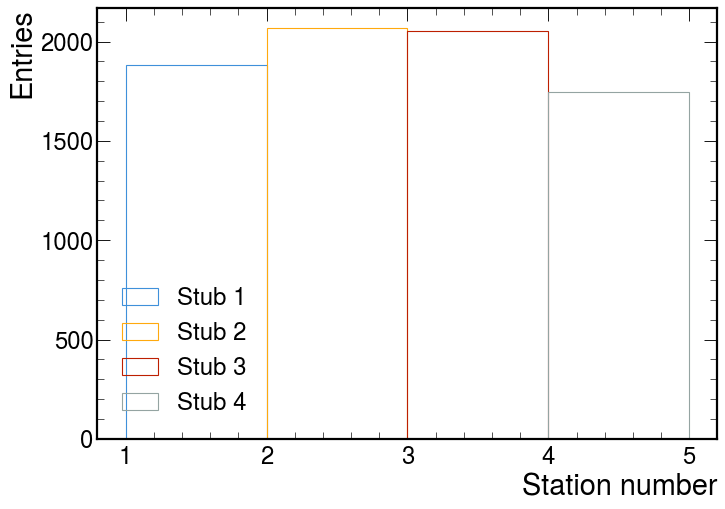

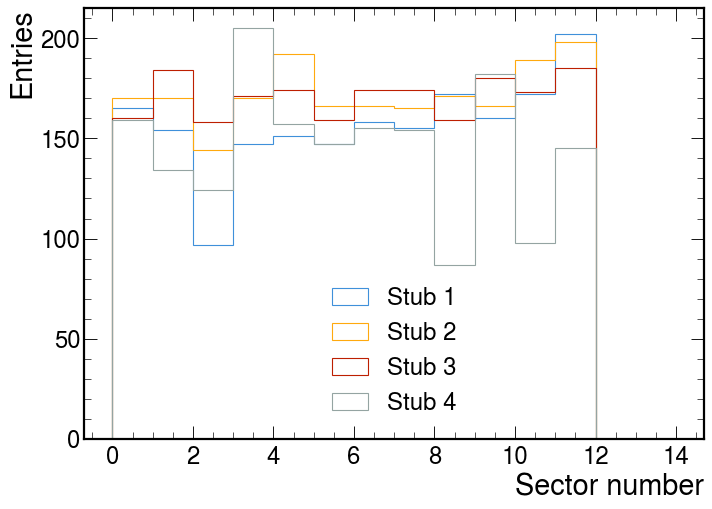

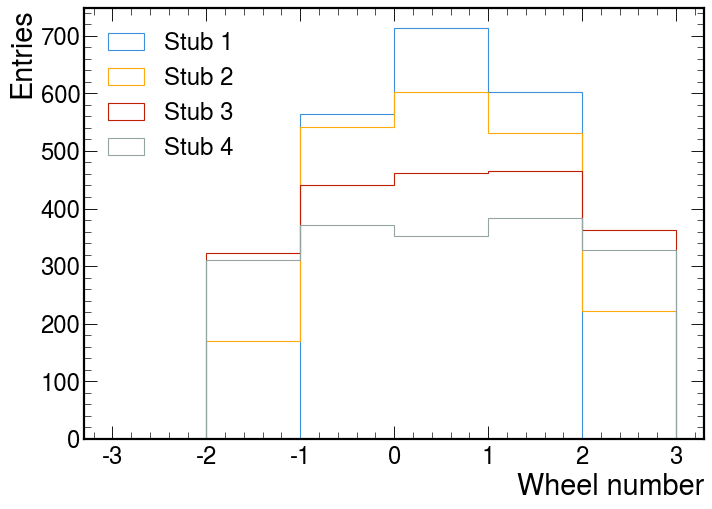

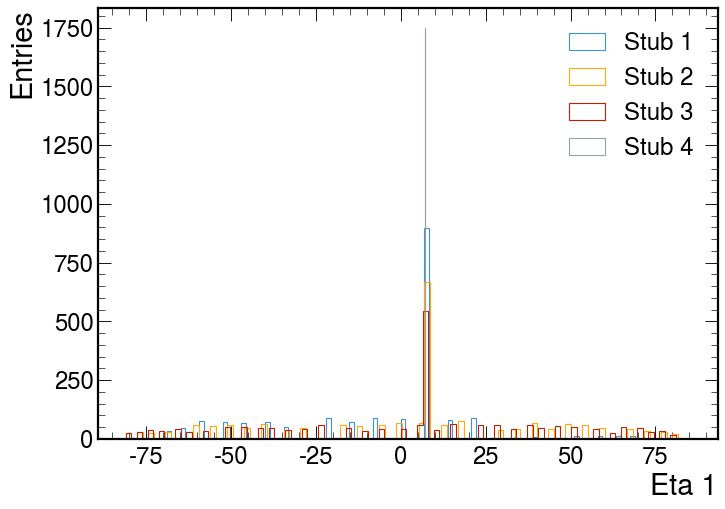

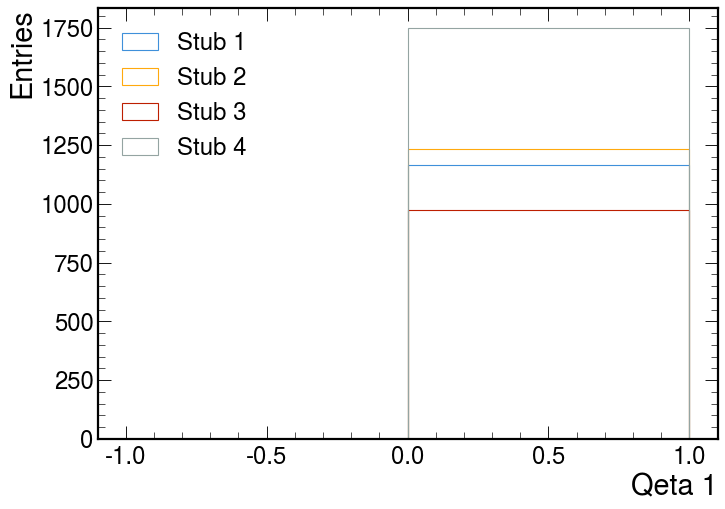

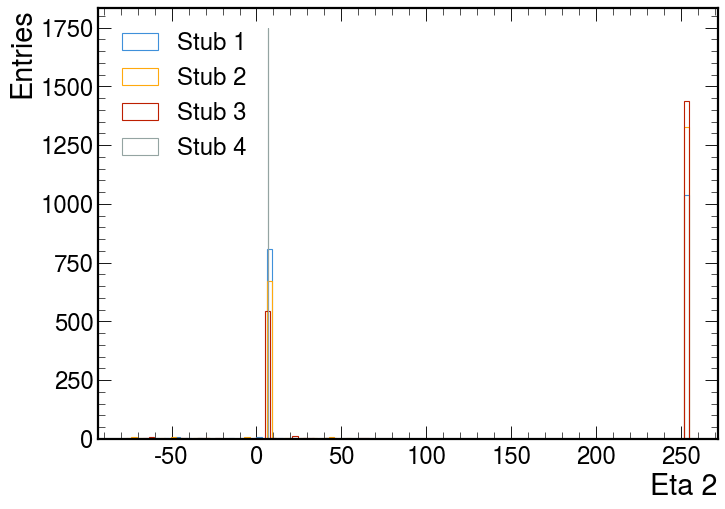

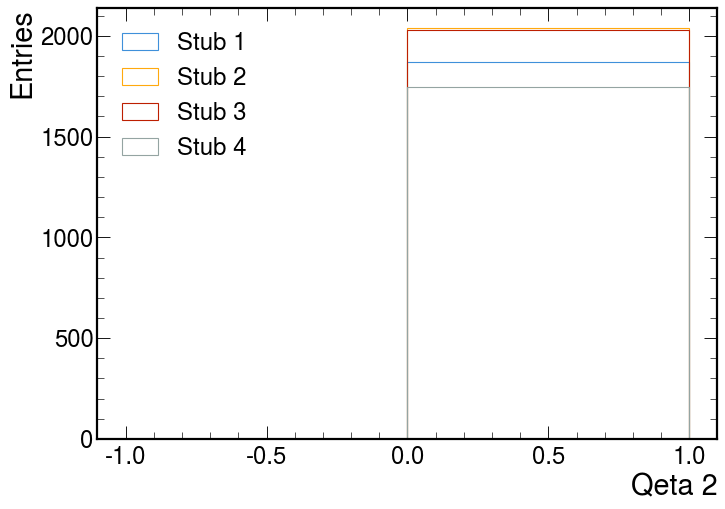

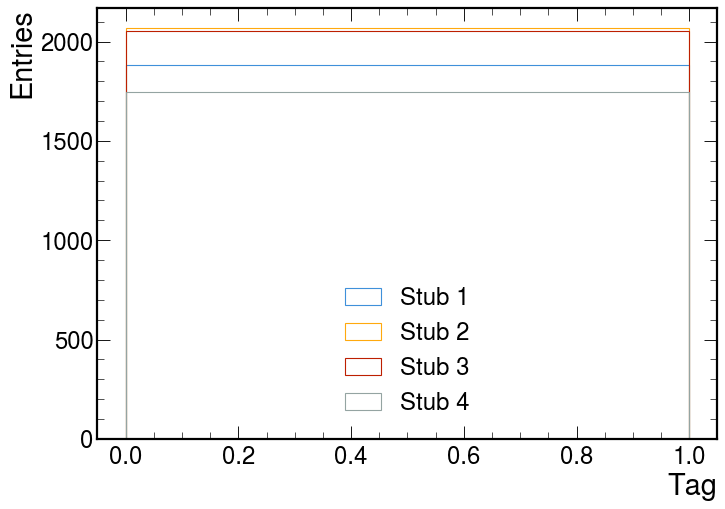

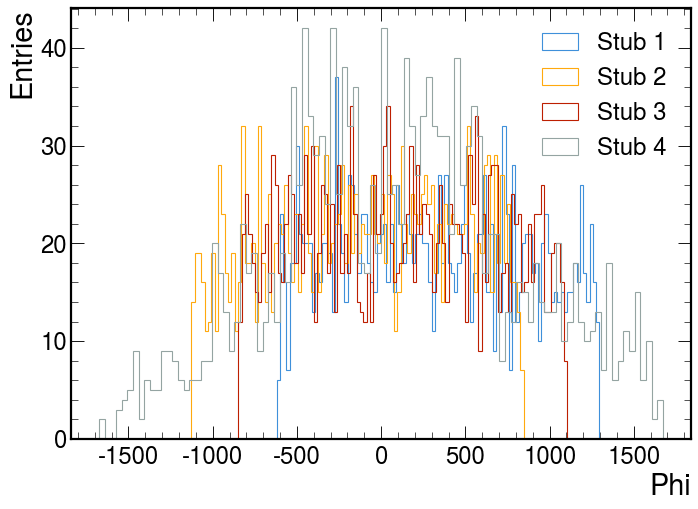

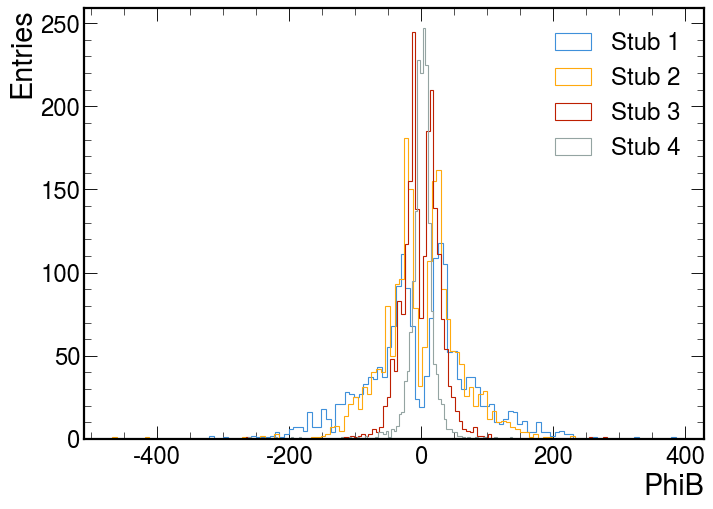

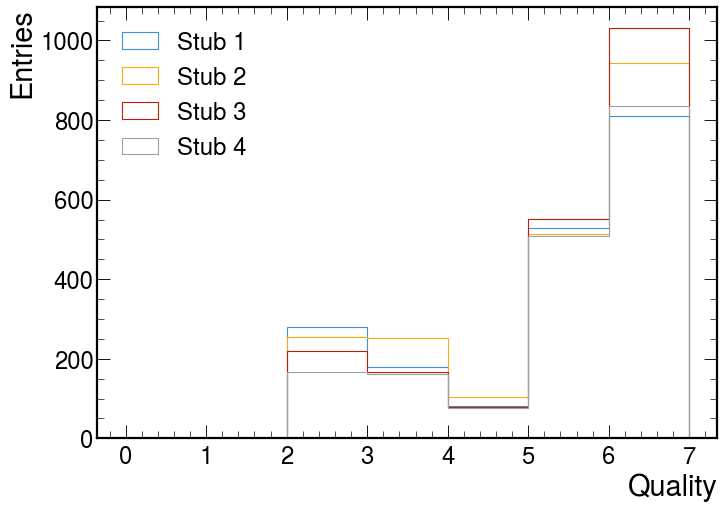

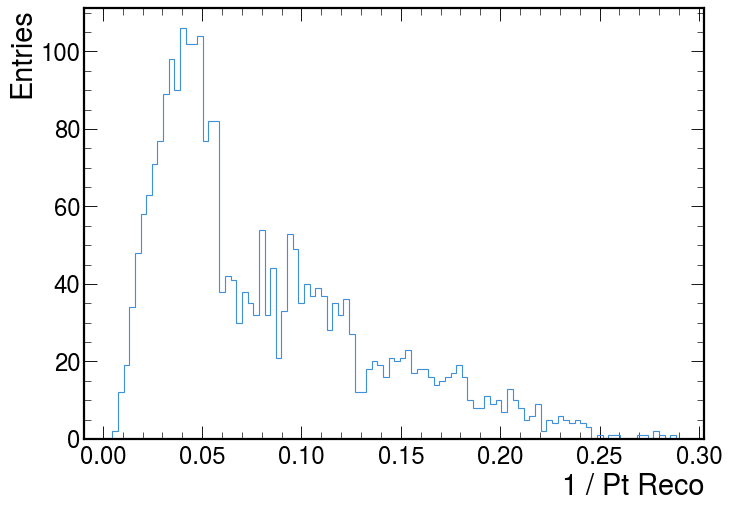

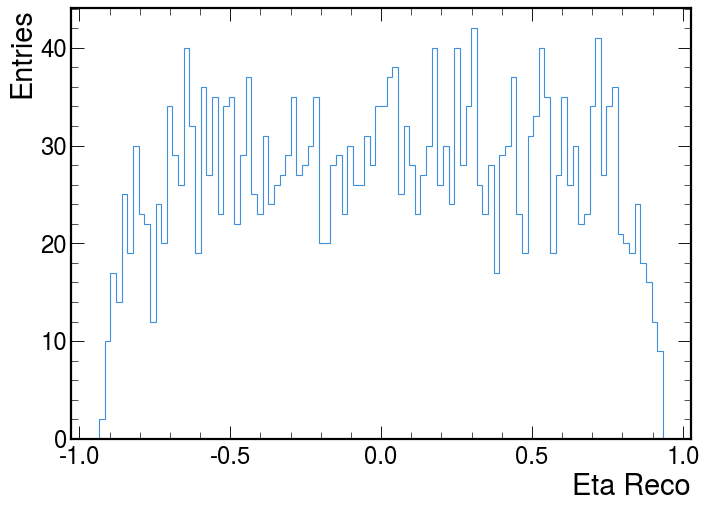

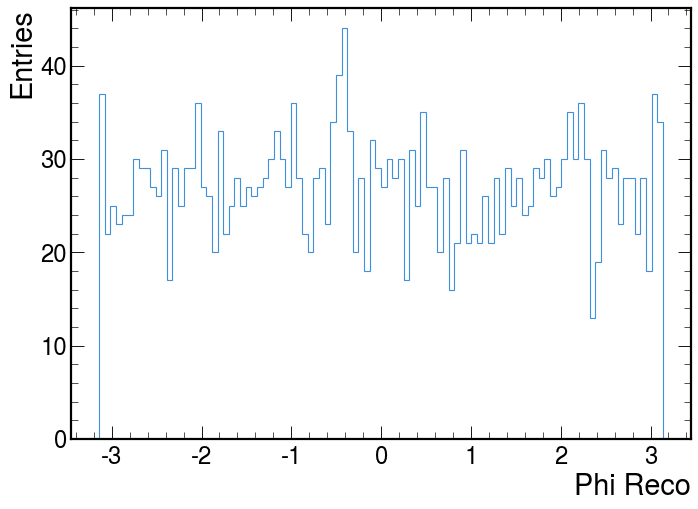

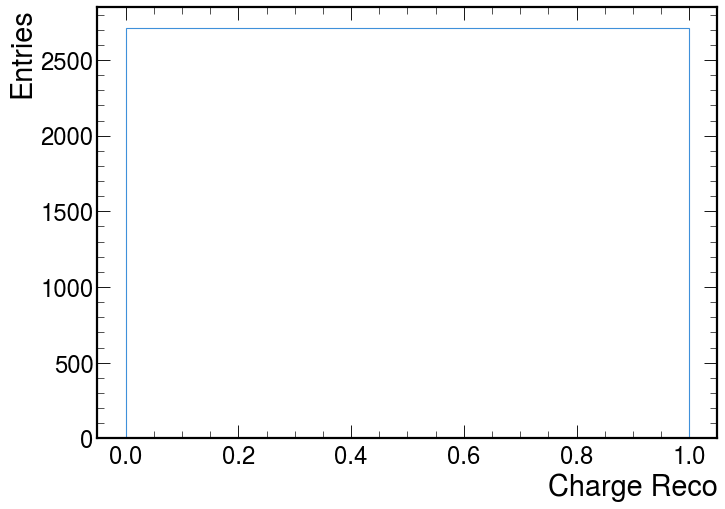

In [33]:
#stNum plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_stNum"].plot.hist(bins=range(1, 6), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Station number")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/stNum.png")
plt.show()

#scNum plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_scNum"].plot.hist(bins=range(0, 15), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Sector number")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/scNum.png")
plt.show()

#whNum plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_whNum"].plot.hist(bins=range(-3, 4), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Wheel number")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/whNum.png")
plt.show()

#eta_1 plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_eta_1"].plot.hist(bins=100, histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Eta 1")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/eta_1.png")
plt.show()


#qeta_1 plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_qeta_1"].plot.hist(bins=range(-1, 2), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Qeta 1")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/qeta_1.png")
plt.show()

#eta_2 plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_eta_2"].plot.hist(bins=100, histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Eta 2")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/eta_2.png")
plt.show()

#qeta_2 plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_qeta_2"].plot.hist(bins=range(-1, 2), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Qeta 2")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/qeta_2.png")
plt.show()

#tag plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_tag"].plot.hist(bins=range(0, 2), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Tag")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/tag.png")
plt.show()

#phi plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_phi"].plot.hist(bins=100, histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Phi")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/phi.png")
plt.show()

#phiB plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_phiB"].plot.hist(bins=100, histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("PhiB")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/phiB.png")
plt.show()

#quality plot
fig, ax = plt.subplots(figsize=FIGSIZE)
for i in range(1, 5):
    full_data[f"s{i}_quality"].plot.hist(bins=range(0, 8), histtype='step', ax=ax, label=f"Stub {i}")
ax.set_xlabel("Quality")
ax.set_ylabel("Entries")
ax.legend()
plt.savefig(f"{OUT_PATH}/Features/quality.png")
plt.show()


#ptRecoInverse plot
fig, ax = plt.subplots(figsize=FIGSIZE)
full_data["ptRecoInverse"].plot.hist(bins=100, histtype='step', ax=ax)
ax.set_xlabel("1 / Pt Reco")
ax.set_ylabel("Entries")
plt.savefig(f"{OUT_PATH}/Features/ptRecoInverse.png")
plt.show()

#etaExtRecoSt2 plot
fig, ax = plt.subplots(figsize=FIGSIZE)
full_data["etaExtRecoSt2"].plot.hist(bins=100, histtype='step', ax=ax)
ax.set_xlabel("Eta Reco")
ax.set_ylabel("Entries")
plt.savefig(f"{OUT_PATH}/Features/etaExtRecoSt2.png")
plt.show()

#phiExtRecoSt2 plot
fig, ax = plt.subplots(figsize=FIGSIZE)
full_data["phiExtRecoSt2"].plot.hist(bins=100, histtype='step', ax=ax)
ax.set_xlabel("Phi Reco")
ax.set_ylabel("Entries")
plt.savefig(f"{OUT_PATH}/Features/phiExtRecoSt2.png")
plt.show()

#chargeReco plot
fig, ax = plt.subplots(figsize=FIGSIZE)
full_data["chargeReco"].plot.hist(bins=range(0, 2), histtype='step', ax=ax)
ax.set_xlabel("Charge Reco")
ax.set_ylabel("Entries")
plt.savefig(f"{OUT_PATH}/Features/chargeReco.png")
plt.show()